In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




In [3]:
# Load the Metro Interstate Traffic Volume dataset using a relative path
# ".." goes one folder up from the current working directory (notebooks)
df = pd.read_csv("../additional_material/Metro_Interstate_Traffic_Volume.csv")

# Show the first rows to confirm it worked
df.head()


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


# Initial data inspection

## Display first, last and a random sample

In [4]:
# Show the first rows
display(df.head())

# Show the last rows
display(df.tail())

# Show a random sample of 5 rows
display(df.sample(5))

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
36674,NaN,290.550,0.0,0.0,40,Haze,haze,2017-08-27 04:00:00,356
2502,NaN,262.730,0.0,0.0,20,Mist,mist,2012-12-29 21:00:00,2429
27454,NaN,276.173,0.0,0.0,0,Clear,Sky is Clear,2016-10-19 23:00:00,951
559,NaN,285.930,0.0,0.0,90,Mist,mist,2012-10-24 09:00:00,5492
27403,NaN,289.640,0.0,0.0,100,Rain,heavy intensity rain,2016-10-17 18:00:00,4048


In [5]:
# Overview of column data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


## Check the timeframe

In [6]:
# Parse datetime and check timeframe for gaps

# Convert the date_time column to a proper datetime type
df["date_time"] = pd.to_datetime(df["date_time"])

# Check the time range
print("Min timestamp:", df["date_time"].min())
print("Max timestamp:", df["date_time"].max())

# Sort by time and set as index
df_time = df.sort_values("date_time").set_index("date_time")

# Create a full hourly time index between min and max
full_range = pd.date_range(start=df_time.index.min(),
                           end=df_time.index.max(),
                           freq="H")

# Find missing timestamps (time gaps)
missing_timestamps = full_range.difference(df_time.index)
print("Number of missing hourly timestamps:", len(missing_timestamps))

# Optional: check how many observations per year-month (to judge sparsity)
df["year"] = df["date_time"].dt.year
df["month"] = df["date_time"].dt.month
obs_per_month = (
    df.groupby(["year", "month"])
      .size()
      .reset_index(name="n_obs")
      .sort_values(["year", "month"])
)
display(obs_per_month.head(20))  # show first 20 rows as an example

# Example: filter to a denser timeframe (adjust dates if needed)
# Here we keep all observations from 2013-01-01 onward
df_filtered = df[df["date_time"] >= "2013-01-01"].copy()


Min timestamp: 2012-10-02 09:00:00
Max timestamp: 2018-09-30 23:00:00
Number of missing hourly timestamps: 11976


C:\Users\USER\AppData\Local\Temp\ipykernel_10976\17347564.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df_time.index.min(),


,year,month,n_obs
0,2012,10,805
1,2012,11,785
2,2012,12,969
3,2013,1,706
4,2013,2,717
5,2013,3,715
6,2013,4,939
7,2013,5,940
8,2013,6,767
9,2013,7,748


In [7]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


display(obs_per_month)

,year,month,n_obs
0,2012,10,805
1,2012,11,785
2,2012,12,969
3,2013,1,706
4,2013,2,717
5,2013,3,715
6,2013,4,939
7,2013,5,940
8,2013,6,767
9,2013,7,748


## Result: In 2014 and 2015 the data was pretty sparse. However, there is data for each month so we decided to keep the whole timeframe.

## Basic summary statistics for numerical variables

In [8]:

numeric_cols = df_filtered.select_dtypes(include=["number"]).columns
display(df_filtered[numeric_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
temp,45645.0,281.554251,13.494447,0.0,272.416,283.52,292.18,310.07
rain_1h,45645.0,0.353004,46.027476,0.0,0.000,0.00,0.00,9831.30
snow_1h,45645.0,0.000235,0.008393,0.0,0.000,0.00,0.00,0.51
clouds_all,45645.0,48.468945,39.064117,0.0,1.000,64.00,90.00,100.00
traffic_volume,45645.0,3262.734516,1986.631149,0.0,1194.000,3388.00,4931.00,7280.00
year,45645.0,2015.709344,1.747783,2013.0,2014.000,2016.00,2017.00,2018.00
month,45645.0,6.250498,3.307714,1.0,4.000,6.00,9.00,12.00


## Encoding categorical variables: Holiday will be binary, weather_main will be hot encoded and weather_description will stay the same, otherwise the data will become to messy.

In [9]:
df_model = df_filtered.copy()


# 1) Make "holiday" binary (0 = no holiday, 1 = holiday)

df_model["holiday_binary"] = df_model["holiday"].notna().astype(int)
df_model = df_model.drop(columns=["holiday"])


# 2) One-hot encode only weather_main

df_model = pd.get_dummies(
    df_model,
    columns=["weather_main"],
    drop_first=True  # avoid perfect multicollinearity
)


# 3) Keep weather_description as-is (do nothing)

# No encoding applied intentionally

print("Final shape:", df_model.shape)
df_model.head()

Final shape: (45645, 20)


,temp,rain_1h,snow_1h,clouds_all,weather_description,date_time,traffic_volume,year,month,holiday_binary,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
2559,263.49,0.0,0.0,58,broken clouds,2013-01-01 00:00:00,1439,2013,1,1,True,False,False,False,False,False,False,False,False,False
2560,263.78,0.0,0.0,40,scattered clouds,2013-01-01 01:00:00,1502,2013,1,0,True,False,False,False,False,False,False,False,False,False
2561,264.16,0.0,0.0,75,heavy snow,2013-01-01 02:00:00,933,2013,1,0,False,False,False,False,False,False,False,True,False,False
2562,263.95,0.0,0.0,90,overcast clouds,2013-01-01 03:00:00,576,2013,1,0,True,False,False,False,False,False,False,False,False,False
2563,263.65,0.0,0.0,90,overcast clouds,2013-01-01 04:00:00,372,2013,1,0,True,False,False,False,False,False,False,False,False,False


In [10]:
df = df_model.copy()

## Convert temperature from farenheit to celcius

In [11]:

# Create a new column for temperature in Celsius
df["temp_c"] = df["temp"] - 273.15

df = df.drop(columns=["temp"])

In [12]:
df.head(5)

,rain_1h,snow_1h,clouds_all,weather_description,date_time,traffic_volume,year,month,holiday_binary,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,temp_c
2559,0.0,0.0,58,broken clouds,2013-01-01 00:00:00,1439,2013,1,1,True,False,False,False,False,False,False,False,False,False,-9.66
2560,0.0,0.0,40,scattered clouds,2013-01-01 01:00:00,1502,2013,1,0,True,False,False,False,False,False,False,False,False,False,-9.37
2561,0.0,0.0,75,heavy snow,2013-01-01 02:00:00,933,2013,1,0,False,False,False,False,False,False,False,True,False,False,-8.99
2562,0.0,0.0,90,overcast clouds,2013-01-01 03:00:00,576,2013,1,0,True,False,False,False,False,False,False,False,False,False,-9.20
2563,0.0,0.0,90,overcast clouds,2013-01-01 04:00:00,372,2013,1,0,True,False,False,False,False,False,False,False,False,False,-9.50


## Encode time date from linear to cyclic representation

In [13]:

# Extract time components
df["hour"] = df["date_time"].dt.hour
df["day_of_week"] = df["date_time"].dt.weekday  # Monday=0, Sunday=6
df["month"] = df["date_time"].dt.month

# Cyclic encoding for hour of day (24 hours)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# Cyclic encoding for day of week (7 days)
df["day_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
df["day_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

# Cyclic encoding for month of year (12 months)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Quick check of the final dataframe
df.head()


,rain_1h,snow_1h,clouds_all,weather_description,date_time,traffic_volume,year,month,holiday_binary,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm,temp_c,hour,day_of_week,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
2559,0.0,0.0,58,broken clouds,2013-01-01 00:00:00,1439,2013,1,1,True,False,False,False,False,False,False,False,False,False,-9.66,0,1,0.000000,1.000000,0.781831,0.62349,0.5,0.866025
2560,0.0,0.0,40,scattered clouds,2013-01-01 01:00:00,1502,2013,1,0,True,False,False,False,False,False,False,False,False,False,-9.37,1,1,0.258819,0.965926,0.781831,0.62349,0.5,0.866025
2561,0.0,0.0,75,heavy snow,2013-01-01 02:00:00,933,2013,1,0,False,False,False,False,False,False,False,True,False,False,-8.99,2,1,0.500000,0.866025,0.781831,0.62349,0.5,0.866025
2562,0.0,0.0,90,overcast clouds,2013-01-01 03:00:00,576,2013,1,0,True,False,False,False,False,False,False,False,False,False,-9.20,3,1,0.707107,0.707107,0.781831,0.62349,0.5,0.866025
2563,0.0,0.0,90,overcast clouds,2013-01-01 04:00:00,372,2013,1,0,True,False,False,False,False,False,False,False,False,False,-9.50,4,1,0.866025,0.500000,0.781831,0.62349,0.5,0.866025


# Check the variables we will use for the model

## 1. Traffic Volume

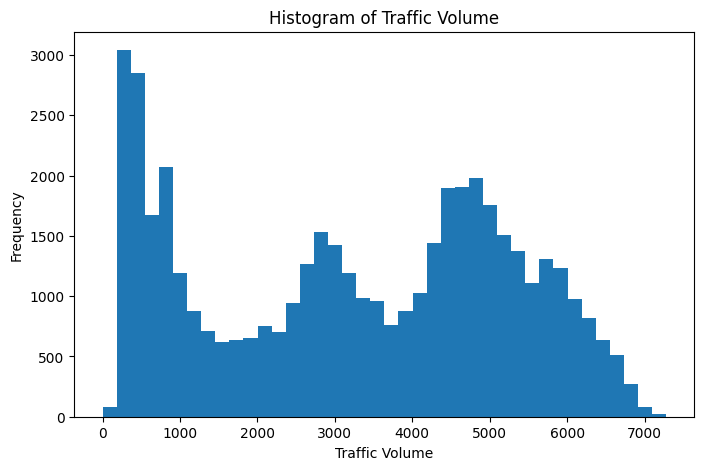

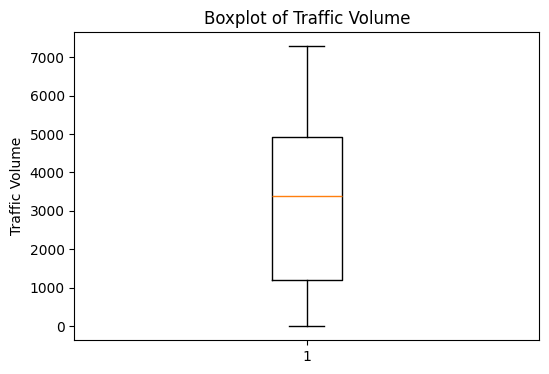

In [14]:
# Histogram of traffic_volume
plt.figure(figsize=(8,5))
plt.hist(df["traffic_volume"], bins=40)
plt.title("Histogram of Traffic Volume")
plt.xlabel("Traffic Volume")
plt.ylabel("Frequency")
plt.show()

# Boxplot of traffic_volume
plt.figure(figsize=(6,4))
plt.boxplot(df["traffic_volume"], vert=True)
plt.title("Boxplot of Traffic Volume")
plt.ylabel("Traffic Volume")
plt.show()

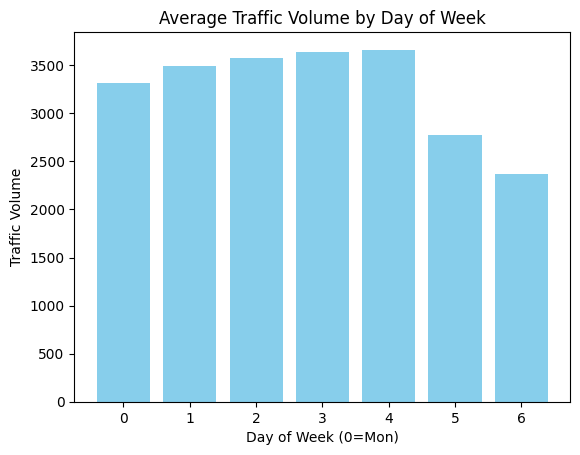

In [15]:
dow = df.groupby("day_of_week")["traffic_volume"].mean()

plt.bar(dow.index, dow.values, color='skyblue')
plt.title("Average Traffic Volume by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Traffic Volume")
plt.show()

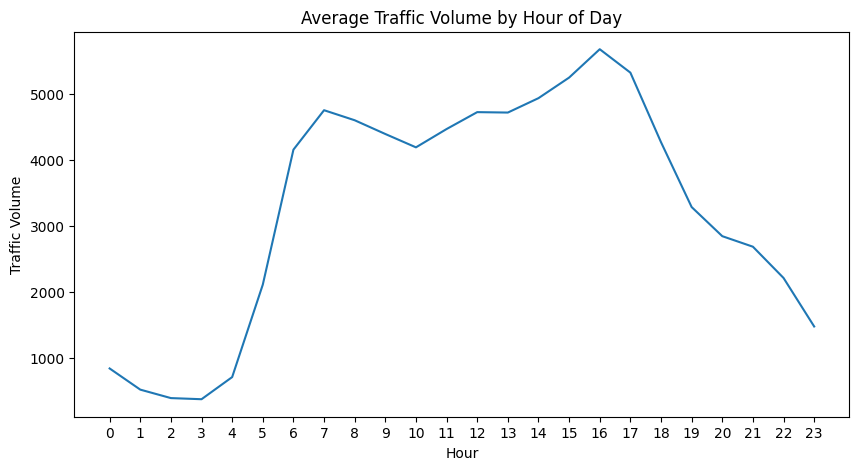

In [16]:
hourly = df.groupby("hour")["traffic_volume"].mean()
plt.figure(figsize=(10,5))
plt.plot(hourly.index, hourly.values)
plt.title("Average Traffic Volume by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Traffic Volume")
plt.xticks(range(0, 24))
plt.show()

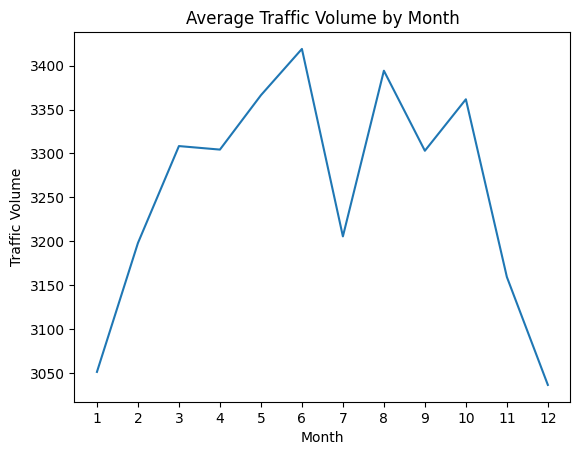

In [17]:
monthly = df.groupby("month")["traffic_volume"].mean()
plt.plot(monthly.index, monthly.values)
plt.title("Average Traffic Volume by Month")
plt.xlabel("Month")
plt.ylabel("Traffic Volume")
plt.xticks(range(1, 13))
plt.show()

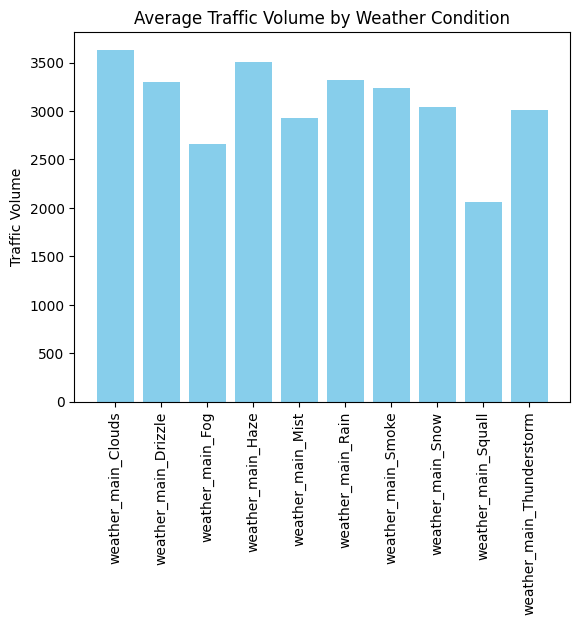

In [18]:
weather_cols = [
    'weather_main_Clouds','weather_main_Drizzle','weather_main_Fog',
    'weather_main_Haze','weather_main_Mist','weather_main_Rain',
    'weather_main_Smoke','weather_main_Snow','weather_main_Squall',
    'weather_main_Thunderstorm'
]
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta',
    'yellow', 'black', 'purple', 'orange', 'lime']

weather_effect = {}
for col in weather_cols:
    weather_effect[col] = df[df[col] == True]["traffic_volume"].mean()

plt.bar(weather_effect.keys(), weather_effect.values(), color='skyblue')
plt.title("Average Traffic Volume by Weather Condition")
plt.ylabel("Traffic Volume")
plt.xticks(rotation=90)
plt.show()

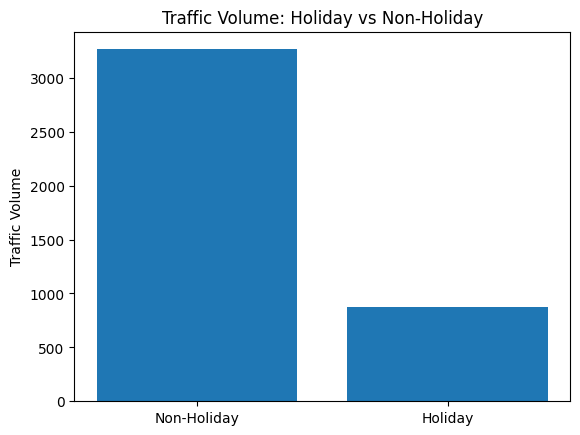

In [19]:
holiday_group = df.groupby("holiday_binary")["traffic_volume"].mean()

plt.bar(["Non-Holiday", "Holiday"], holiday_group.values)
plt.title("Traffic Volume: Holiday vs Non-Holiday")
plt.ylabel("Traffic Volume")
plt.show()

## 2. Independet variables

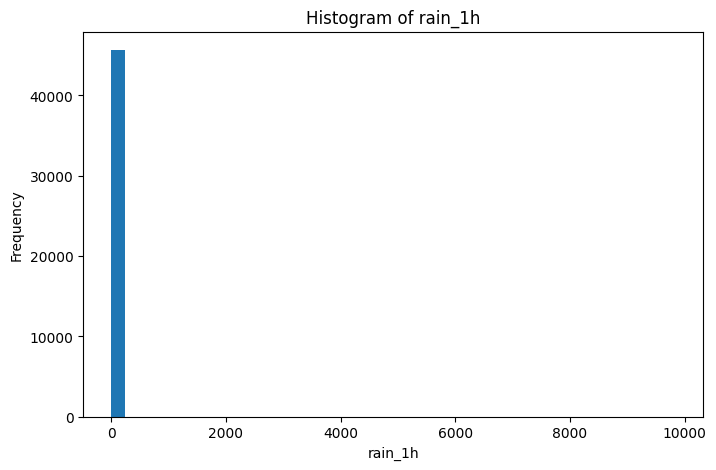

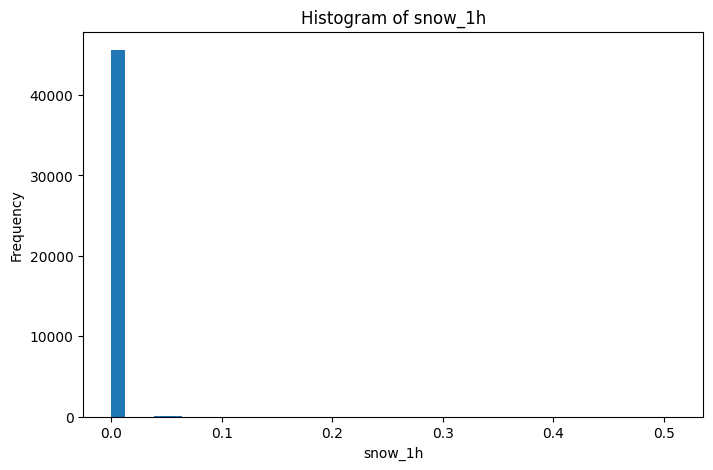

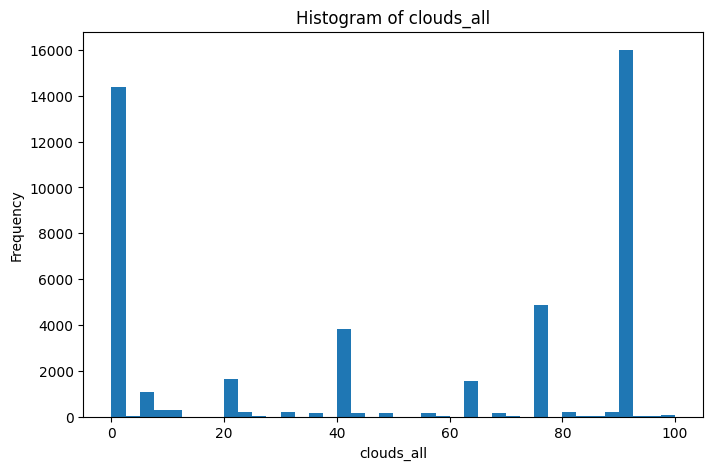

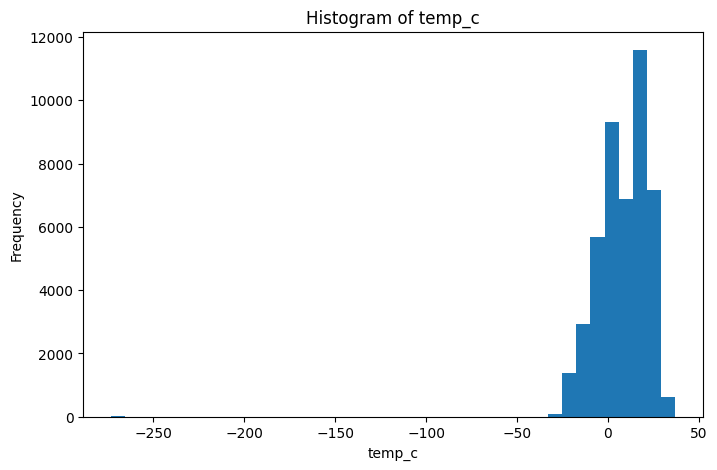

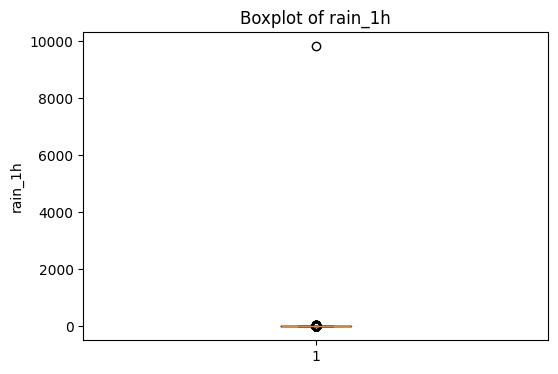

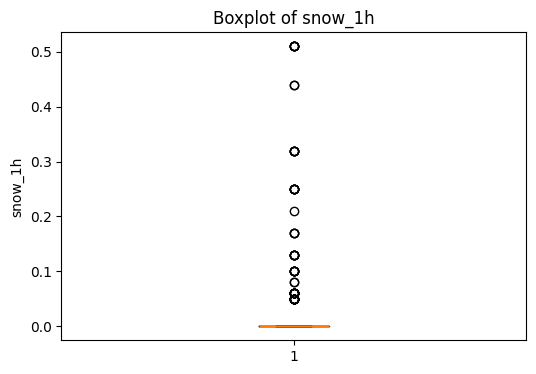

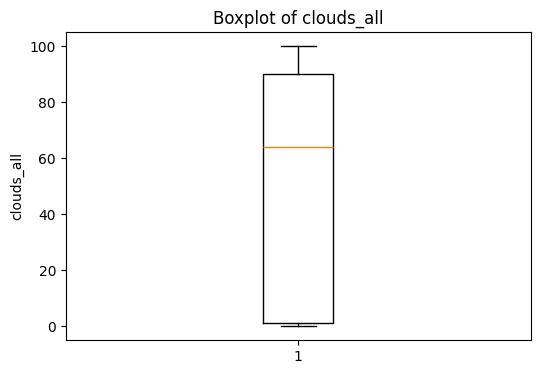

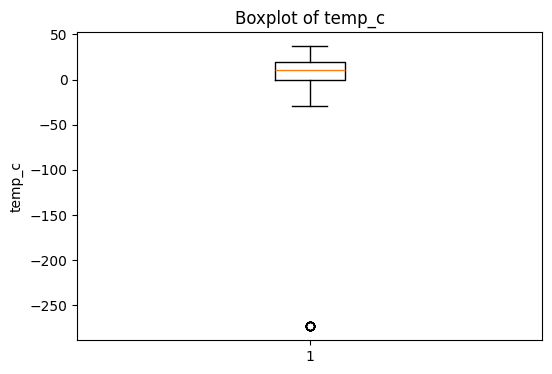

In [20]:


# List of variables to visualize
vars_to_plot = ["rain_1h", "snow_1h", "clouds_all", "temp_c"]

# Histograms
for var in vars_to_plot:
    plt.figure(figsize=(8,5))
    plt.hist(df[var], bins=40)
    plt.title(f"Histogram of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.show()

# Boxplots
for var in vars_to_plot:
    plt.figure(figsize=(6,4))
    plt.boxplot(df[var], vert=True)
    plt.title(f"Boxplot of {var}")
    plt.ylabel(var)
    plt.show()


In [21]:
df.columns

Index(['rain_1h', 'snow_1h', 'clouds_all', 'weather_description', 'date_time',
       'traffic_volume', 'year', 'month', 'holiday_binary',
       'weather_main_Clouds', 'weather_main_Drizzle', 'weather_main_Fog',
       'weather_main_Haze', 'weather_main_Mist', 'weather_main_Rain',
       'weather_main_Smoke', 'weather_main_Snow', 'weather_main_Squall',
       'weather_main_Thunderstorm', 'temp_c', 'hour', 'day_of_week',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos'],
      dtype='object')

## There seem to be outliers for rain_1h and temperature

In [22]:
# check outliers:

# Look at the largest rain_1h values
df.sort_values("rain_1h", ascending=False)[
    ["date_time", "rain_1h", "snow_1h", "temp_c", "traffic_volume"]
].head(10)


,date_time,rain_1h,snow_1h,temp_c,traffic_volume
24872,2016-07-11 17:00:00,9831.30,0.0,28.96,5535
8247,2013-08-07 02:00:00,55.63,0.0,15.95,315
7179,2013-06-24 11:00:00,44.45,0.0,22.67,4802
25779,2016-08-16 17:00:00,31.75,0.0,24.56,4913
10806,2013-12-19 23:00:00,28.70,0.0,-8.65,1190
10807,2013-12-19 23:00:00,28.70,0.0,-8.65,1190
16505,2015-07-13 00:00:00,27.57,0.0,18.87,492
16506,2015-07-13 00:00:00,27.57,0.0,18.87,492
16504,2015-07-13 00:00:00,27.57,0.0,18.87,492
17439,2015-08-16 21:00:00,25.46,0.0,21.34,2118


In [23]:
# Look at the smallest temperatures
df.sort_values("temp_c", ascending=True)[
    ["date_time", "rain_1h", "snow_1h", "temp_c", "traffic_volume"]
].head(10)

,date_time,rain_1h,snow_1h,temp_c,traffic_volume
11898,2014-01-31 03:00:00,0.0,0.0,-273.15,361
11901,2014-01-31 06:00:00,0.0,0.0,-273.15,5150
11900,2014-01-31 05:00:00,0.0,0.0,-273.15,2557
11899,2014-01-31 04:00:00,0.0,0.0,-273.15,734
11947,2014-02-02 04:00:00,0.0,0.0,-273.15,284
11946,2014-02-02 03:00:00,0.0,0.0,-273.15,291
11950,2014-02-02 07:00:00,0.0,0.0,-273.15,962
11951,2014-02-02 08:00:00,0.0,0.0,-273.15,1670
11948,2014-02-02 05:00:00,0.0,0.0,-273.15,434
11949,2014-02-02 06:00:00,0.0,0.0,-273.15,739


In [24]:
# Manually remove obvious erroneous values

# 1) Define masks for the unrealistic values
#    (adjust the conditions if needed)
mask_rain_error = df["rain_1h"] > 1000       # the single huge rain value
mask_temp_error = df["temp_c"] <= -200       # the -273.15 °C rows

# 2) Optionally inspect them before dropping
display(df[mask_rain_error][["date_time", "rain_1h", "temp_c", "traffic_volume"]])
display(df[mask_temp_error][["date_time", "rain_1h", "temp_c", "traffic_volume"]])

# 3) Drop those rows from df
df = df[~(mask_rain_error | mask_temp_error)].copy()

print("New shape after manual removal:", df.shape)


,date_time,rain_1h,temp_c,traffic_volume
24872,2016-07-11 17:00:00,9831.3,28.96,5535


,date_time,rain_1h,temp_c,traffic_volume
11898,2014-01-31 03:00:00,0.0,-273.15,361
11899,2014-01-31 04:00:00,0.0,-273.15,734
11900,2014-01-31 05:00:00,0.0,-273.15,2557
11901,2014-01-31 06:00:00,0.0,-273.15,5150
11946,2014-02-02 03:00:00,0.0,-273.15,291
11947,2014-02-02 04:00:00,0.0,-273.15,284
11948,2014-02-02 05:00:00,0.0,-273.15,434
11949,2014-02-02 06:00:00,0.0,-273.15,739
11950,2014-02-02 07:00:00,0.0,-273.15,962
11951,2014-02-02 08:00:00,0.0,-273.15,1670


New shape after manual removal: (45634, 28)


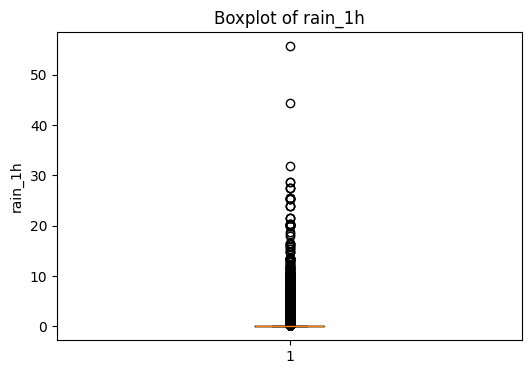

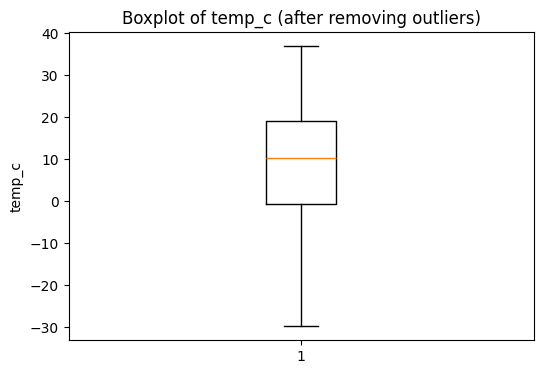

In [25]:
# Boxplot for rain_1h
plt.figure(figsize=(6,4))
plt.boxplot(df["rain_1h"], vert=True)
plt.title("Boxplot of rain_1h")
plt.ylabel("rain_1h")
showfliers=False
plt.show()

# Boxplot for temp_c
plt.figure(figsize=(6,4))
plt.boxplot(df["temp_c"], vert=True)
plt.title("Boxplot of temp_c (after removing outliers)")
plt.ylabel("temp_c")
plt.show()


In [26]:
mean_y = df['traffic_volume'].mean()
var_y = df['traffic_volume'].var()

dispersion_index = var_y / mean_y

print(f"Mean: {mean_y:.2f}")
print(f"Variance: {var_y:.2f}")
print(f"Dispersion Index: {dispersion_index:.2f}")


Mean: 3263.11
Variance: 3946253.31
Dispersion Index: 1209.35


In [27]:
df = df.sort_values("date_time")

train_size = int(0.8 * len(df))
train = df.iloc[:train_size]
test  = df.iloc[train_size:]
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (36507, 28)
Test shape: (9127, 28)


In [28]:
formula = """
traffic_volume ~
    temp_c +
    rain_1h + snow_1h + clouds_all +
    holiday_binary +
    hour_sin + hour_cos +
    day_sin + day_cos +
    month_sin + month_cos +
    weather_main_Clouds +
    weather_main_Drizzle +
    weather_main_Fog +
    weather_main_Haze +
    weather_main_Mist +
    weather_main_Rain +
    weather_main_Smoke +
    weather_main_Snow +
    weather_main_Squall +
    weather_main_Thunderstorm """


### Poisson Model 

In [29]:
poisson_model = smf.glm(
    formula=formula,
    data=train,
    family=sm.families.Poisson()
).fit()
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         traffic_volume   No. Observations:                36507
Model:                            GLM   Df Residuals:                    36485
Model Family:                 Poisson   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0783e+07
Date:                Tue, 23 Dec 2025   Deviance:                   2.1216e+07
Time:                        02:24:07   Pearson chi2:                 2.15e+07
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

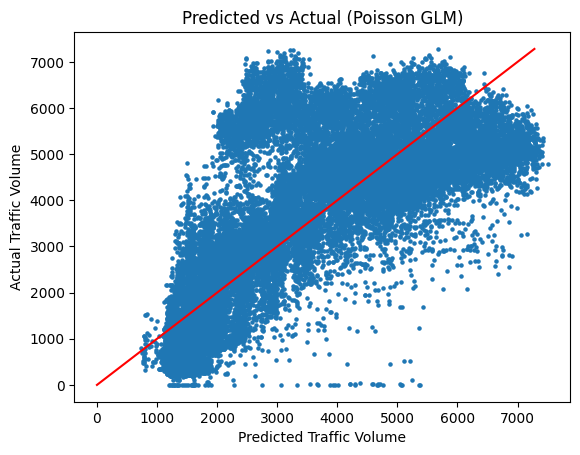

In [30]:
plt.scatter(poisson_model.fittedvalues, train["traffic_volume"], s=5)
plt.xlabel("Predicted Traffic Volume")
plt.ylabel("Actual Traffic Volume")
plt.title("Predicted vs Actual (Poisson GLM)")
plt.plot([0, max(train["traffic_volume"])], [0, max(train["traffic_volume"])], color='red')  # 45° line
plt.show()


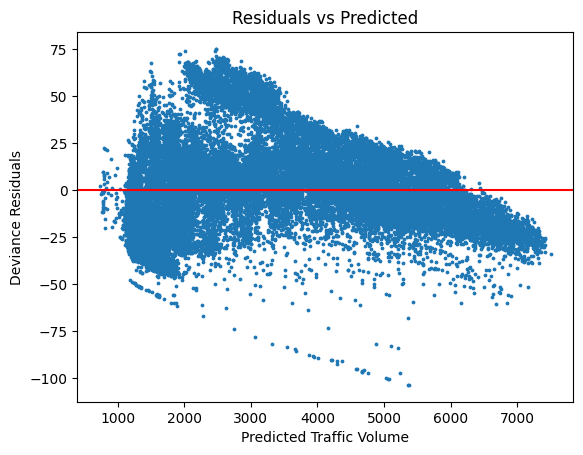

In [31]:
residuals = poisson_model.resid_deviance
plt.scatter(poisson_model.fittedvalues, residuals, s=3)
plt.axhline((0),color='red')
plt.xlabel("Predicted Traffic Volume")
plt.ylabel("Deviance Residuals")
plt.title("Residuals vs Predicted")
plt.show()


In [32]:
alpha = 61.55
preds_poisson_adj = poisson_model.predict(test) * alpha
mu = poisson_model.mu
resid = poisson_model.resid_response

alpha = np.mean((resid**2 - mu) / mu**2)
print("Estimated alpha:", alpha)
preds_poisson_adj = poisson_model.predict(test) * alpha

Estimated alpha: 0.25588284646769416


In [33]:
pearson_poisson = np.sum(poisson_model.resid_pearson ** 2)
dispersion_poisson = pearson_poisson / poisson_model.df_resid

print("Poisson Dispersion:", dispersion_poisson)


Poisson Dispersion: 588.8484530295065


## Poisson Model Null-Model

In [34]:
poisson_null = smf.glm(
    formula="traffic_volume ~ 1",
    data=train,
    family=sm.families.Poisson()
).fit()

print(poisson_null.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         traffic_volume   No. Observations:                36507
Model:                            GLM   Df Residuals:                    36506
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.6451e+07
Date:                Tue, 23 Dec 2025   Deviance:                   5.2552e+07
Time:                        02:24:08   Pearson chi2:                 4.44e+07
No. Iterations:                     6   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0915   9.16e-05   8.84e+04      0.0

### Negative Binomial Model 

In [35]:
nb_model = smf.glm(
    formula=formula,
    data=train,
    family=sm.families.NegativeBinomial(alpha=alpha)
).fit()

print(nb_model.summary())
preds_nb = nb_model.predict(test)


                 Generalized Linear Model Regression Results                  
Dep. Variable:         traffic_volume   No. Observations:                36507
Model:                            GLM   Df Residuals:                    36485
Model Family:        NegativeBinomial   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1533e+05
Date:                Tue, 23 Dec 2025   Deviance:                       45332.
Time:                        02:24:08   Pearson chi2:                 4.38e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.7454
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

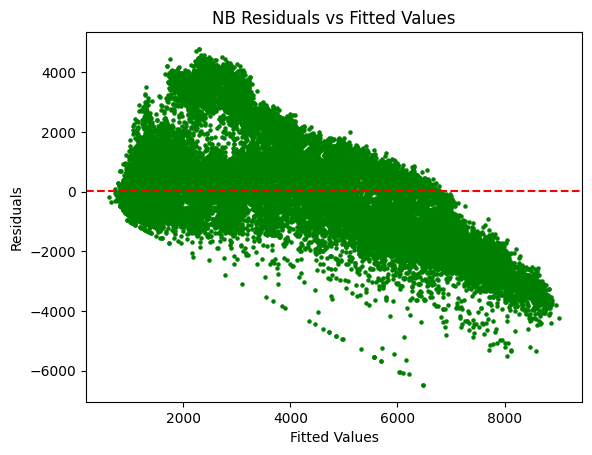

In [36]:
nb_residuals = train["traffic_volume"] - nb_model.fittedvalues

plt.scatter(nb_model.fittedvalues, nb_residuals, s=5,color='green')
plt.title("NB Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.axhline(10, color='red', linestyle='--')
plt.show()


In [37]:
print("Poisson AIC:", poisson_model.aic)
print("NB AIC:", nb_model.aic)
print("Poisson BIC:", poisson_model.bic)
print("NB BIC:", nb_model.bic)

Poisson AIC: 21566446.687949613
NB AIC: 630713.696409915
Poisson BIC: 20832866.051288992
NB BIC: -337952.8175047002


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


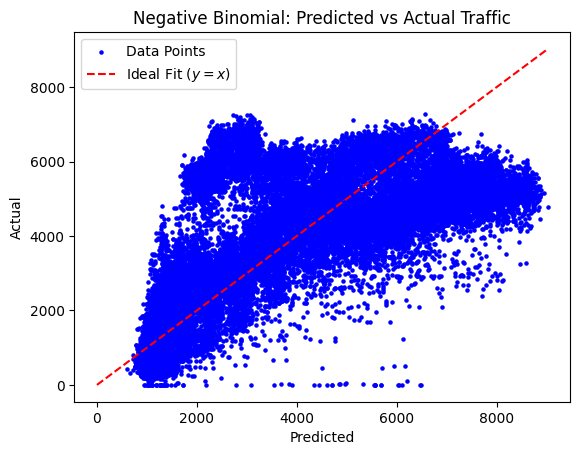

In [38]:
# 1. Determine the range for the ideal fit line
min_val = min(nb_model.fittedvalues.min(), train["traffic_volume"].min())
max_val = max(nb_model.fittedvalues.max(), train["traffic_volume"].max())
line_coords = np.linspace(min_val, max_val, 100)

# 2. Plot the data points (blue)
plt.scatter(nb_model.fittedvalues, train["traffic_volume"],
            s=5, label="Data Points", color='blue')

# 3. Plot the ideal y=x line (red)
plt.plot(line_coords, line_coords,
         color='red', linestyle='--', label='Ideal Fit ($y=x$)')

# 4. Add titles, labels, and legend
plt.title("Negative Binomial: Predicted vs Actual Traffic")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.legend()
plt.show()

In [39]:
def mcfadden_r2(model):
    ll_full = model.llf
    ll_null = model.null_deviance / -2
    return 1 - (ll_full / ll_null)

print("Poisson McFadden R²:", mcfadden_r2(poisson_model))
print("NB McFadden R²:", mcfadden_r2(nb_model))


Poisson McFadden R²: 0.5896200889079599
NB McFadden R²: -5.6195179150619134


In [40]:
pearson_nb = np.sum(nb_model.resid_pearson ** 2)
dispersion_nb = pearson_nb / nb_model.df_resid

print("NB Dispersion:", dispersion_nb)


NB Dispersion: 1.2005071214082097


In [41]:
test["pred_nb"] = nb_model.predict(test)
test["pred_poisson"] = poisson_model.predict(test)
test[["traffic_volume", "pred_nb", "pred_poisson"]].head(10)


C:\Users\USER\AppData\Local\Temp\ipykernel_10976\2227238604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred_nb"] = nb_model.predict(test)
C:\Users\USER\AppData\Local\Temp\ipykernel_10976\2227238604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred_poisson"] = poisson_model.predict(test)


,traffic_volume,pred_nb,pred_poisson
39077,4852,4079.878825,3658.988459
39078,4556,3270.059530,3102.495886
39079,3733,2570.515810,2566.757606
39080,3181,2017.789439,2098.501020
39081,3011,1599.041798,1750.977667
39082,3358,1302.324110,1495.913555
39083,3347,1104.353845,1320.012079
39084,1529,936.004316,1165.060534
39085,996,889.762430,1125.323323
39086,726,901.751537,1142.961758


### NB Null Model

In [42]:
nb_null = smf.glm(
    formula="traffic_volume ~ 1",
    data=train,
    family=sm.families.NegativeBinomial(alpha=alpha)
).fit()

print(nb_null.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         traffic_volume   No. Observations:                36507
Model:                            GLM   Df Residuals:                    36506
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4031e+05
Date:                Tue, 23 Dec 2025   Deviance:                       95274.
Time:                        02:24:09   Pearson chi2:                 5.30e+04
No. Iterations:                     5   Pseudo R-squ. (CS):          3.667e-12
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0915      0.003   3054.472      0.0

### Testing Prediction 

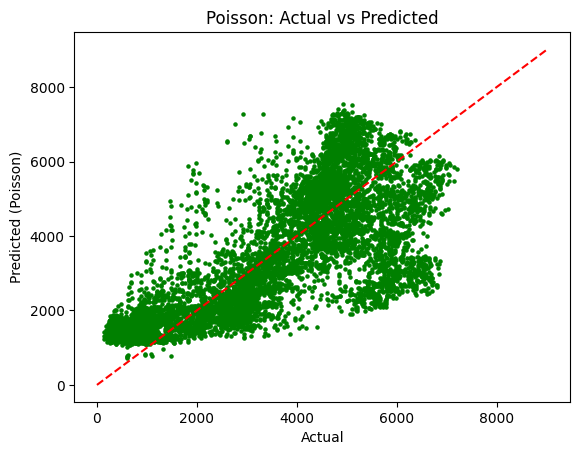

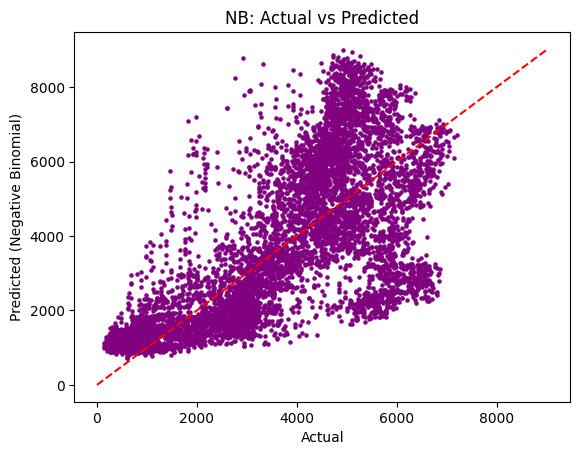

In [43]:
plt.scatter(test["traffic_volume"], test["pred_poisson"],color='green',s=5)
plt.xlabel("Actual")
plt.ylabel("Predicted (Poisson)")
plt.title("Poisson: Actual vs Predicted")
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')
plt.show()

plt.scatter(test["traffic_volume"], test["pred_nb"], color='purple',s=5)
plt.xlabel("Actual")
plt.ylabel("Predicted (Negative Binomial)")
plt.title("NB: Actual vs Predicted")
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')
plt.show()


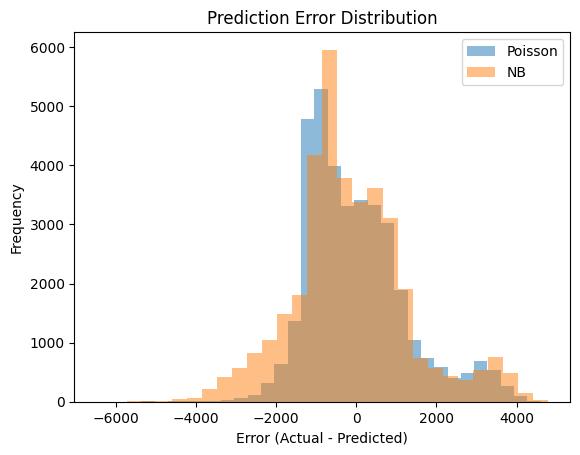

In [44]:
poisson_error = train["traffic_volume"] - poisson_model.fittedvalues
nb_error = train["traffic_volume"] - nb_model.fittedvalues

plt.hist(poisson_error, bins=30, alpha=0.5, label="Poisson")
plt.hist(nb_error, bins=30, alpha=0.5, label="NB")
plt.title("Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Comparing Poisson and Negative Binomial Models

In [45]:


y = test["traffic_volume"]
y_poisson = test["pred_poisson"]
y_nb = test["pred_nb"]

# denominator for MAPE (avoiding division by zero) — only needs to be defined once
denom = np.where(y == 0, 1, y)

# ===== Poisson =====
mae_p  = mean_absolute_error(y, y_poisson)
rmse_p = np.sqrt(mean_squared_error(y, y_poisson))
mape_p = np.mean(np.abs((y - y_poisson) / denom)) * 100
r2_p   = r2_score(y, y_poisson)
corr_p = np.corrcoef(y, y_poisson)[0, 1]

# ===== Negative Binomial =====
mae_n  = mean_absolute_error(y, y_nb)
rmse_n = np.sqrt(mean_squared_error(y, y_nb))
mape_n = np.mean(np.abs((y - y_nb) / denom)) * 100
r2_n   = r2_score(y, y_nb)
corr_n = np.corrcoef(y, y_nb)[0, 1]

# ===== Output =====
print("=== Model Comparison (Poisson vs NegBin) ===")
print(f"{'Metric':<10} {'Poisson':>12} {'NegBin':>12}")
print("-" * 38)
print(f"MAE       {mae_p:12.3f} {mae_n:12.3f}")
print(f"RMSE      {rmse_p:12.3f} {rmse_n:12.3f}")
print(f"MAPE%     {mape_p:12.3f} {mape_n:12.3f}")
print(f"R²        {r2_p:12.3f} {r2_n:12.3f}")
print(f"Corr      {corr_p:12.3f} {corr_n:12.3f}")


=== Model Comparison (Poisson vs NegBin) ===
Metric          Poisson       NegBin
--------------------------------------
MAE           1006.782     1147.630
RMSE          1266.657     1491.280
MAPE%           72.588       62.754
R²               0.583        0.422
Corr             0.769        0.748


Interpretation of this is done in the report. tldr Poisson performs better in general. NB is slightly better at lower volume (mape %).

Here is the interpretation again, now in full sentences:

The **MAE (Mean Absolute Error)** shows how far predictions deviate from true values on average, and Poisson performs better because its error is smaller.
The **RMSE (Root Mean Squared Error)** highlights larger mistakes more strongly, and Poisson performs better here as well, indicating fewer extreme errors.
The **MAPE (Mean Absolute Percentage Error)** measures deviation in percentage terms, and in this case the Negative Binomial performs better because its relative error is lower. Measuring the percentage error puts an emphasis on smaller numbers.
The **R² value** shows how much variance in the data the model can explain, and Poisson performs better by capturing more of the underlying structure.
The **correlation coefficient** measures how closely predictions follow the ups and downs of the true series, and Poisson performs slightly better here too.

In summary, the Poisson model outperforms the Negative Binomial model in most evaluation metrics and delivers more accurate and consistent predictions, while the Negative Binomial only shows an advantage when performance is judged relative to actual values.


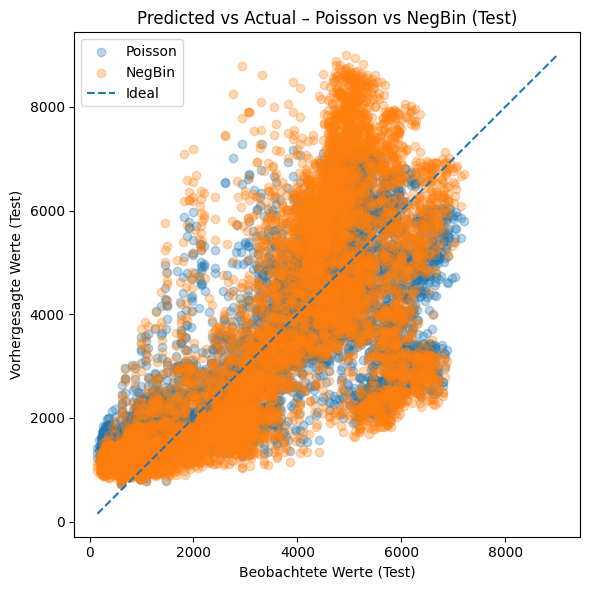

In [46]:
plt.figure(figsize=(6, 6))
plt.scatter(test["traffic_volume"], test["pred_poisson"], alpha=0.3, label="Poisson")
plt.scatter(test["traffic_volume"], test["pred_nb"], alpha=0.3, label="NegBin")

min_val = min(test["traffic_volume"].min(),
              test["pred_poisson"].min(),
              test["pred_nb"].min())
max_val = max(test["traffic_volume"].max(),
              test["pred_poisson"].max(),
              test["pred_nb"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", label="Ideal")

plt.xlabel("Beobachtete Werte (Test)")
plt.ylabel("Vorhergesagte Werte (Test)")
plt.title("Predicted vs Actual – Poisson vs NegBin (Test)")
plt.legend()
plt.tight_layout()
plt.show()

## Filling out the report

In [47]:
def get_examples(col):
    """Return up to 3 example values, rounded to 2 decimals if numeric."""
    examples = col.dropna().unique()[:3]
    rounded = []
    for v in examples:
        if isinstance(v, (int, float, np.number)):
            rounded.append(round(float(v), 2))
        else:
            rounded.append(v)
    return str(rounded)

# Create summary table
structure = pd.DataFrame({
    "Feature / Variable": df.columns,
    "Data type": df.dtypes.astype(str),
    "Description": ["" for _ in df.columns],  # fill manually later
    "Number of unique values": df.nunique().values,
    "Example values": df.apply(get_examples, axis=0)
})

# Display the table
structure


,Feature / Variable,Data type,Description,Number of unique values,Example values
rain_1h,rain_1h,float64,,371,"[0.0, 0.25, 0.57]"
snow_1h,snow_1h,float64,,12,"[0.0, 0.51, 0.32]"
clouds_all,clouds_all,int64,,50,"[58.0, 40.0, 75.0]"
weather_description,weather_description,object,,38,"['broken clouds', 'scattered clouds', 'heavy s..."
date_time,date_time,datetime64[ns],,38461,"[Timestamp('2013-01-01 00:00:00'), Timestamp('..."
traffic_volume,traffic_volume,int64,,6669,"[1439.0, 1502.0, 933.0]"
year,year,int32,,6,"[2013.0, 2014.0, 2015.0]"
month,month,int32,,12,"[1.0, 2.0, 3.0]"
holiday_binary,holiday_binary,int64,,2,"[1.0, 0.0]"
weather_main_Clouds,weather_main_Clouds,bool,,2,"[np.True_, np.False_]"


In [48]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Compute descriptive statistics
desc = df[numeric_cols].describe().T

# Add variance
desc["variance"] = df[numeric_cols].var()

# Add dispersion index (variance / mean)
desc["dispersion_index"] = desc["variance"] / desc["mean"]

# Round everything to 2 decimals
desc = desc.round(2)

# Rename index to "Variable"
desc.index.name = "Variable"

# Display table
desc


,count,mean,std,min,25%,50%,75%,max,variance,dispersion_index
Variable,,,,,,,,,,
rain_1h,45634.0,0.14,1.03,0.00,0.00,0.00,0.00,55.63,1.06,7.72
snow_1h,45634.0,0.00,0.01,0.00,0.00,0.00,0.00,0.51,0.00,0.30
clouds_all,45634.0,48.48,39.06,0.00,1.00,64.00,90.00,100.00,1525.84,31.47
traffic_volume,45634.0,3263.11,1986.52,0.00,1194.00,3389.00,4931.75,7280.00,3946253.31,1209.35
year,45634.0,2015.71,1.75,2013.00,2014.00,2016.00,2017.00,2018.00,3.05,0.00
month,45634.0,6.25,3.31,1.00,4.00,6.00,9.00,12.00,10.94,1.75
holiday_binary,45634.0,0.00,0.04,0.00,0.00,0.00,0.00,1.00,0.00,1.00
temp_c,45634.0,8.47,12.84,-29.76,-0.73,10.38,19.03,36.92,164.76,19.46
hour,45634.0,11.40,6.95,0.00,5.00,11.00,17.00,23.00,48.26,4.23


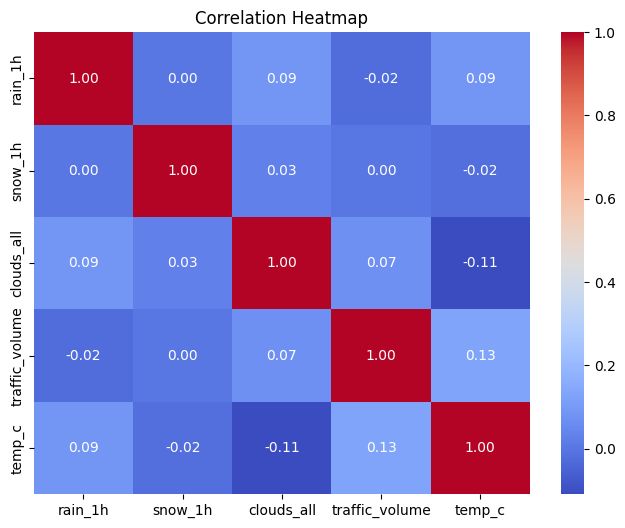

In [49]:

# Select variables for correlation
corr_vars = ["rain_1h", "snow_1h", "clouds_all", "traffic_volume", "temp_c"]

# Compute correlation matrix
corr_matrix = df[corr_vars].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
